# Mengimport LIbrary

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model

# Load DataSet

In [ ]:
# Load data from CSV
df = pd.read_csv('/content/Dataset Japri Final  - Data Pekerjaan.csv')

# Extract 'Deskripsi Diri' and 'Nama Pekerjaan' from the dataframe
deskripsi_diri = df['Deskripsi Diri'].values.astype('str')
bidang_pekerjaan = df['Nama Pekerjaan'].values.astype('str')

df.head()

,ID,Nama Pekerjaan,Bidang Pekerjaan,Deskripsi Diri
0,1,Petugas Kebersihan Kamar (DW),Pelayanan,Melaksanakan dengan teliti dan penuh tanggung ...
1,2,Petugas Kebersihan Kamar (DW),Pelayanan,Menjaga standar kebersihan yang tinggi dan mem...
2,3,Petugas Kebersihan Kamar (DW),Pelayanan,Melakukan tugas-tugas rutin pembersihan dengan...
3,4,Asisten Baking dan Formulasi (DW),Pelayanan,Mendukung proses pembuatan produk roti dan kue...
4,5,Asisten Baking dan Formulasi (DW),Pelayanan,Berperan dalam mengembangkan resep-resep baru ...


# Labeling & Split Data

In [ ]:
# Inisialisasi Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')

# Tokenisasi deskripsi pekerjaan
tokenized_deskripsi = tokenizer(deskripsi_diri.tolist(), padding=True, truncation=True, return_tensors="tf")

# Konversi nama pekerjaan menjadi label numerik
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(bidang_pekerjaan)

# Split data menjadi training dan testing menggunakan train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_deskripsi.input_ids.numpy(),
    encoded_labels,
    test_size=0.2,  # Ubah sesuai kebutuhan
    random_state=42
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Membuat Arsitektur & Pelatihan Model

In [ ]:
# Membuat model BERT untuk mengubah deskripsi pekerjaan menjadi vektor
bert_model = TFBertModel.from_pretrained('cahya/bert-base-indonesian-522M')
input_ids = tf.keras.Input(shape=(None,), dtype='int32')
bert_output = bert_model(input_ids)[0]

# Fine tuning
for layer in bert_model.layers[:-6]:
    layer.trainable = False

# Menambahkan lapisan Dense untuk klasifikasi nama pekerjaan
x = Dropout(0.3)(bert_output[:, 0, :])
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(units=len(np.unique(encoded_labels)), activation='softmax')(x)

# Membuat model
model = Model(inputs=input_ids, outputs=output)

# Kompilasi model untuk pelatihan
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Melatih model dengan validasi
history = model.fit(train_inputs, train_labels, epochs=35, batch_size=16, validation_split=0.1)

Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/35


97/97 [==============================] - 79s 244ms/step - loss: 5.4598 - accuracy: 0.0065 - val_loss: 5.3309 - val_accuracy: 0.0000e+00
Epoch 2/35
97/97 [==============================] - 19s 199ms/step - loss: 5.3649 - accuracy: 0.0084 - val_loss: 5.3397 - val_accuracy: 0.0058
Epoch 3/35
97/97 [==============================] - 19s 194ms/step - loss: 5.3019 - accuracy: 0.0155 - val_loss: 5.1883 - val_accuracy: 0.0405
Epoch 4/35
97/97 [==============================] - 19s 201ms/step - loss: 5.0986 - accuracy: 0.0355 - val_loss: 4.8226 - val_accuracy: 0.0809
Epoch 5/35
97/97 [==============================] - 19s 198ms/step - loss: 4.6698 - accuracy: 0.1039 - val_loss: 4.1865 - val_accuracy: 0.2312
Epoch 6/35
97/97 [==============================] - 19s 197ms/step - loss: 4.0963 - accuracy: 0.2071 - val_loss: 3.5013 - val_accuracy: 0.3642
Epoch 7/35
97/97 [==============================] - 19s 197ms/step - loss: 3.4140 - accuracy: 0.3574 - val_loss: 2.9082 - val_accuracy: 0.5318
Epoch 

# Membuat Diagram Akurasi dan Loss

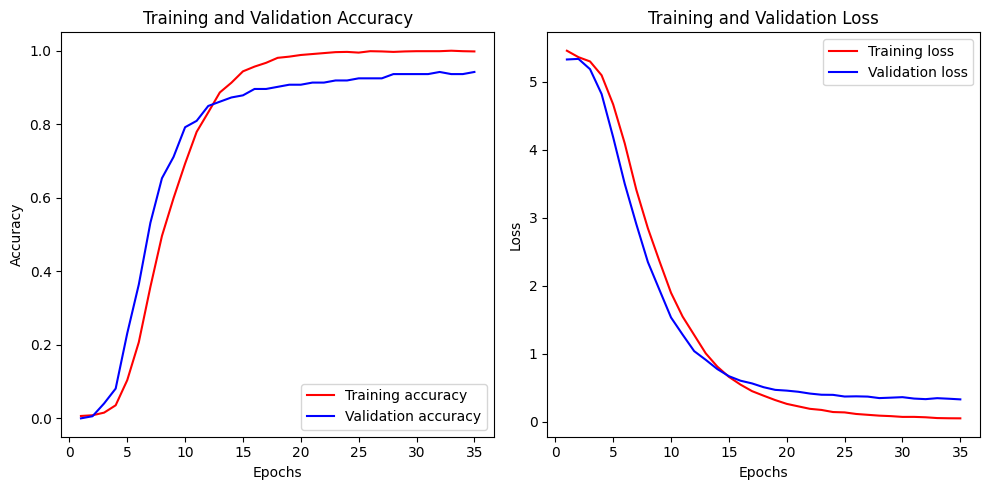

In [ ]:
# Ambil nilai akurasi dan loss dari setiap epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting akurasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Melakukan Pencarian kerja

In [ ]:
# Definisikan threshold di luar fungsi
threshold_value = 0.15  # Nilai threshold yang diinginkan

def predict_job_description(description, threshold=threshold_value):
    # Tokenisasi deskripsi pekerjaan baru dari input pengguna (asumsi: tokenizer, model, dan label_encoder telah didefinisikan sebelumnya)
    tokenized_new_description = tokenizer(description.lower(), padding=True, truncation=True, return_tensors="tf")

    # Lakukan prediksi menggunakan model yang sudah dilatih
    predictions = model.predict(tokenized_new_description.input_ids.numpy())

    # Ambil indeks dengan nilai probabilitas tertinggi untuk setiap kelas
    top_indices = np.argsort(predictions, axis=1)[0][::-1]
    top_probabilities = np.sort(predictions, axis=1)[0][::-1]

    # Inisialisasi similarity scores
    similarity_scores = []

    # Konversi kembali indeks menjadi nama pekerjaan jika probabilitas melebihi threshold
    for i, idx in enumerate(top_indices):
        if top_probabilities[i] >= threshold:
            job_name = label_encoder.inverse_transform([idx])[0]
            similarity_scores.append((job_name, top_probabilities[i]))  # Simpan pasangan (job, similarity_score)
        else:
            break  # Berhenti jika probabilitas tidak memenuhi threshold

    return similarity_scores

# Meminta input dari pengguna
deskripsi_input_pengguna = input("Gambarkan kondisi pekerjaan yang diinginkan: ")

# Menggunakan fungsi prediksi untuk memperoleh rekomendasi pekerjaan
predicted_jobs_above_threshold = predict_job_description(deskripsi_input_pengguna.lower())

# Menampilkan hasil prediksi
if predicted_jobs_above_threshold:
    print("Pekerjaan yang direkomendasikan untuk kondisi yang diberikan:")
    for job, similarity_score in predicted_jobs_above_threshold:
        print(f"{job} - Similarity Score: {similarity_score}")
else:
    print("Tidak ada pekerjaan yang memenuhi.")

KeyboardInterrupt: ignored

# Simpan dan Load Model

In [ ]:

# Menyimpan model
# Simpan model dalam format TensorFlow
model.save('model.h5')

# Load Model
# Definisikan kelas TFBertModel sebagai custom_objects saat memuat model
custom_objects = {'TFBertModel': TFBertModel}

loaded_model = load_model('model.h5', custom_objects=custom_objects)  # Assuming 'model.h5' is in the correct path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Coba Deploy Model dengan Flask

In [ ]:
!pip install flask-ngrok


In [ ]:
!pip install pyngrok


In [ ]:
!ngrok authtoken '2ZXLVijm6dbtVurWdFZgN8mI63X_4anDjpbMs9P7cq33Kps4g'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### - Model ML bisa mendeteksi Satu Pekerjaan

In [ ]:
from flask import Flask, request, jsonify, render_template
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from pyngrok import ngrok

app = Flask(__name__)

# Load the dataset
df = pd.read_csv('/content/Dataset Japri Final - Data Pekerjaan.csv')

# Extract 'Deskripsi Diri' and 'Nama Pekerjaan' from the dataframe
deskripsi_diri = df['Deskripsi Diri'].values.astype('str')
bidang_pekerjaan = df['Nama Pekerjaan'].values.astype('str')

# Initialize the tokenizer and the label encoder
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')
label_encoder = LabelEncoder()

# Fit the label encoder
label_encoder.fit(bidang_pekerjaan)

# Load the model
# Define TFBertModel class as custom_objects when loading the model
from transformers import TFBertModel

custom_objects = {'TFBertModel': TFBertModel}
loaded_model = load_model('model.h5', custom_objects=custom_objects)  # Assuming 'model.h5' is in the correct path

@app.route('/', methods=['GET'])
def home():
    return "<h1>Selamat datang di aplikasi prediksi pekerjaan!</h1>"

@app.route('/form', methods=['GET'])
def show_form():
    return render_template('form.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.form['input']

    # Tokenize the input
    tokenized_input = tokenizer(data, padding=True, truncation=True, return_tensors="tf")

    # Run the model
    prediction = loaded_model.predict(tokenized_input.input_ids.numpy())

    # Postprocess the prediction
    predicted_label = np.argmax(prediction, axis=-1)
    predicted_job = label_encoder.inverse_transform(predicted_label)

    return render_template('result.html', prediction=predicted_job[0])

if __name__ == '__main__':
    public_url = ngrok.connect(5000)
    print(f" * Running on {public_url}")
    app.run()

 * Running on NgrokTunnel: "https://bf0b-35-226-55-127.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Dec/2023 04:27:45] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2023 04:27:45] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2023 04:27:50] "GET /form HTTP/1.1" 200 -


### - Model ML bisa mendeteksi Lebih dari Satu Pekerjaan

In [ ]:
from flask import Flask, request, render_template
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from pyngrok import ngrok

app = Flask(__name__)

# Load the dataset
df = pd.read_csv('/content/Dataset Japri Final - Data Pekerjaan.csv')

# Extract 'Deskripsi Diri' and 'Nama Pekerjaan' from the dataframe
deskripsi_diri = df['Deskripsi Diri'].values.astype('str')
bidang_pekerjaan = df['Nama Pekerjaan'].values.astype('str')

# Initialize the tokenizer, model, and label encoder
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')
custom_objects = {'TFBertModel': TFBertModel}
loaded_model = load_model('model.h5', custom_objects=custom_objects)  # Assuming 'model.h5' is in the correct path
label_encoder = LabelEncoder()
label_encoder.fit(bidang_pekerjaan)

threshold_value = 0.15  # Threshold value for similarity

def predict_job_description(description, threshold=threshold_value):
    tokenized_new_description = tokenizer(description.lower(), padding=True, truncation=True, return_tensors="tf")
    predictions = loaded_model.predict(tokenized_new_description.input_ids.numpy())
    top_indices = np.argsort(predictions, axis=1)[0][::-1]
    top_probabilities = np.sort(predictions, axis=1)[0][::-1]

    similarity_scores = []
    for i, idx in enumerate(top_indices):
        if top_probabilities[i] >= threshold:
            job_name = label_encoder.inverse_transform([idx])[0]
            similarity_scores.append((job_name, top_probabilities[i]))

    return similarity_scores

@app.route('/', methods=['GET'])
def home():
    return "<h1>Selamat datang di aplikasi prediksi pekerjaan!</h1>"

@app.route('/form', methods=['GET'])
def show_form():
    return render_template('form.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.form['input']

    # Get recommended jobs based on input description
    predicted_jobs_above_threshold = predict_job_description(data.lower())

    # Display the predicted jobs
    if predicted_jobs_above_threshold:
        return render_template('result.html', predictions=predicted_jobs_above_threshold)
    else:
        return "Tidak ada pekerjaan yang memenuhi."

if __name__ == '__main__':
    public_url = ngrok.connect(5000)
    print(f" * Running on {public_url}")
    app.run()